# Text and Tweets Analysis Of the impact of Using ChatGpt

### Yahia Chammami

In [1]:
# import the key libraries

import chart_studio
import re
import string
import collections
import ipywidgets
import cufflinks
import nltk.tokenize

import pandas as pd
import datetime
import seaborn as sns
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import nltk
import gensim
import yfinance as yf

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from tqdm.notebook import tqdm
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yahya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yahya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yahya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#read and copy the input Kaggle dataset
tweet_df = pd.read_csv('TwitterJanMar23.csv')
tweet_df.head()

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0
1,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0
2,2023-03-29 22:57:53+00:00,1641213115684536323,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0
3,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0
4,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0


In [3]:
df = tweet_df.copy(deep = True)

#Remove missing values
df = df.dropna()
print("Shape: ",df.shape)


Shape:  (499974, 6)


In [4]:
#edit the date column

df['date'] = pd.to_datetime(df['date'])

df['date'] = df['date'].dt.date

df['date'] = pd.to_datetime(df['date'])

#Checking range of dates
print("Start Date: " ,df['date'].min())
print("End Date: " ,df['date'].max())


Start Date:  2023-01-04 00:00:00
End Date:  2023-03-29 00:00:00


In [5]:
#Let's introduce the preprocessing function
def pre_process(text):
    
# Remove links
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

# Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

# Remove multiple space characters
    text = re.sub('\s+',' ', text)

# Convert to lowercase
    text = text.lower()
    return text


In [6]:
df['processed_content'] = df['content'].apply(pre_process)


In [7]:
#Let's sort the data frame and keep only the first tweet copy with max likes

df_sorted = df.sort_values(by='like_count', ascending=False)

df_cleaned = df_sorted.drop_duplicates(subset='processed_content', keep='first')

df_final = df_cleaned.sort_index()
df = df_final
print (df.shape)


(458210, 7)


In [8]:
df.columns

Index(['date', 'id', 'content', 'username', 'like_count', 'retweet_count',
       'processed_content'],
      dtype='object')

In [9]:
#NLP EDA
#Let's perform topic Modeling LDA using 10k most liked tweets

df_sorted = df.sort_values(by='like_count', ascending=False)
df_top_10000 = df_sorted.iloc[:10000]

In [10]:
#Text Preprocessing:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
docs = df_top_10000['processed_content'].apply(lambda x: [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])

In [11]:
#Create a dictionary of words and their frequency
dictionary = corpora.Dictionary(docs)

#Create a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in docs]

#Topic modeling using LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

correlation = df['like_count'].corr(df['retweet_count'])
print("Pearson correlation coefficient between likes and retweets:", correlation)

Pearson correlation coefficient between likes and retweets: 0.7311855334622003


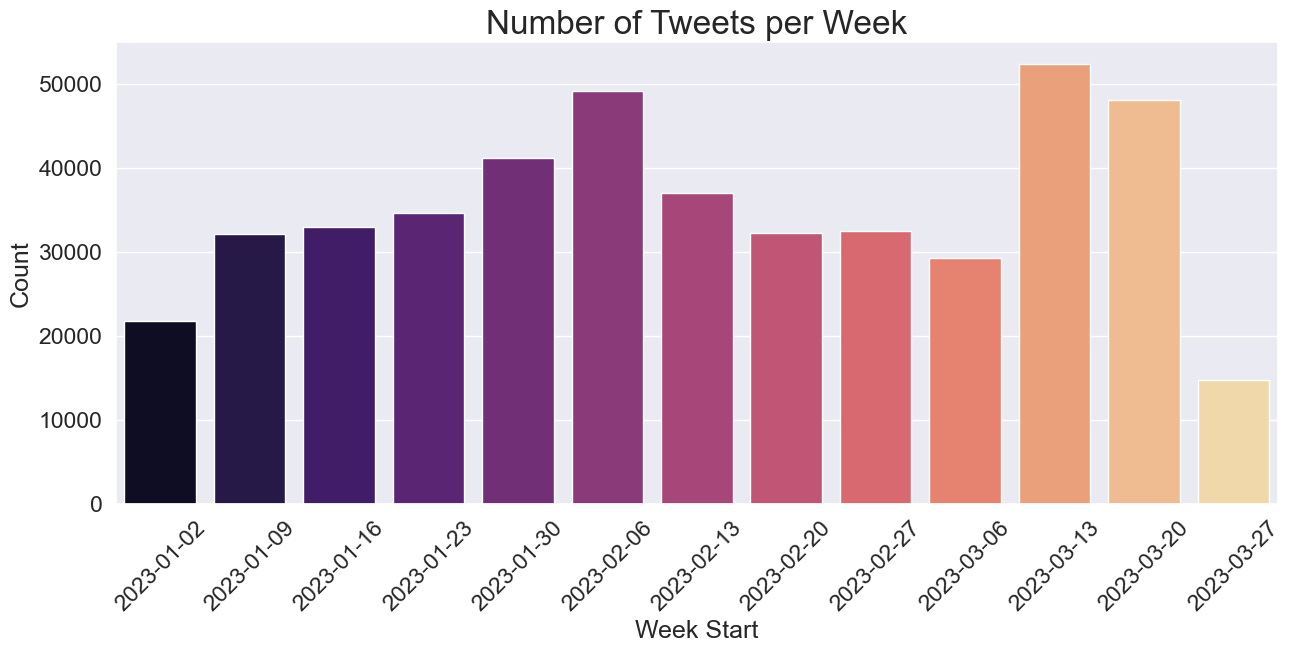

In [12]:
#Let's look at the number of tweets per week (bar plot)
tweets_by_week = df.groupby(pd.Grouper(key='date', freq='W-MON',label='left')).size().reset_index()
tweets_by_week.columns = ['week', 'count']
tweets_by_week['week_start'] = tweets_by_week['week'].dt.strftime('%Y-%m-%d')
tweets_by_week['week_end'] = (tweets_by_week['week'] + pd.Timedelta(days=6)).dt.strftime('%Y-%m-%d')

sns.set(font_scale=1.5)
plt.figure(figsize=(15, 6))
sns.barplot(data=tweets_by_week, x='week_start', y='count', palette='magma')
plt.title('Number of Tweets per Week',fontsize=24)
plt.xticks(rotation=45)
plt.xlabel('Week Start',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.show()



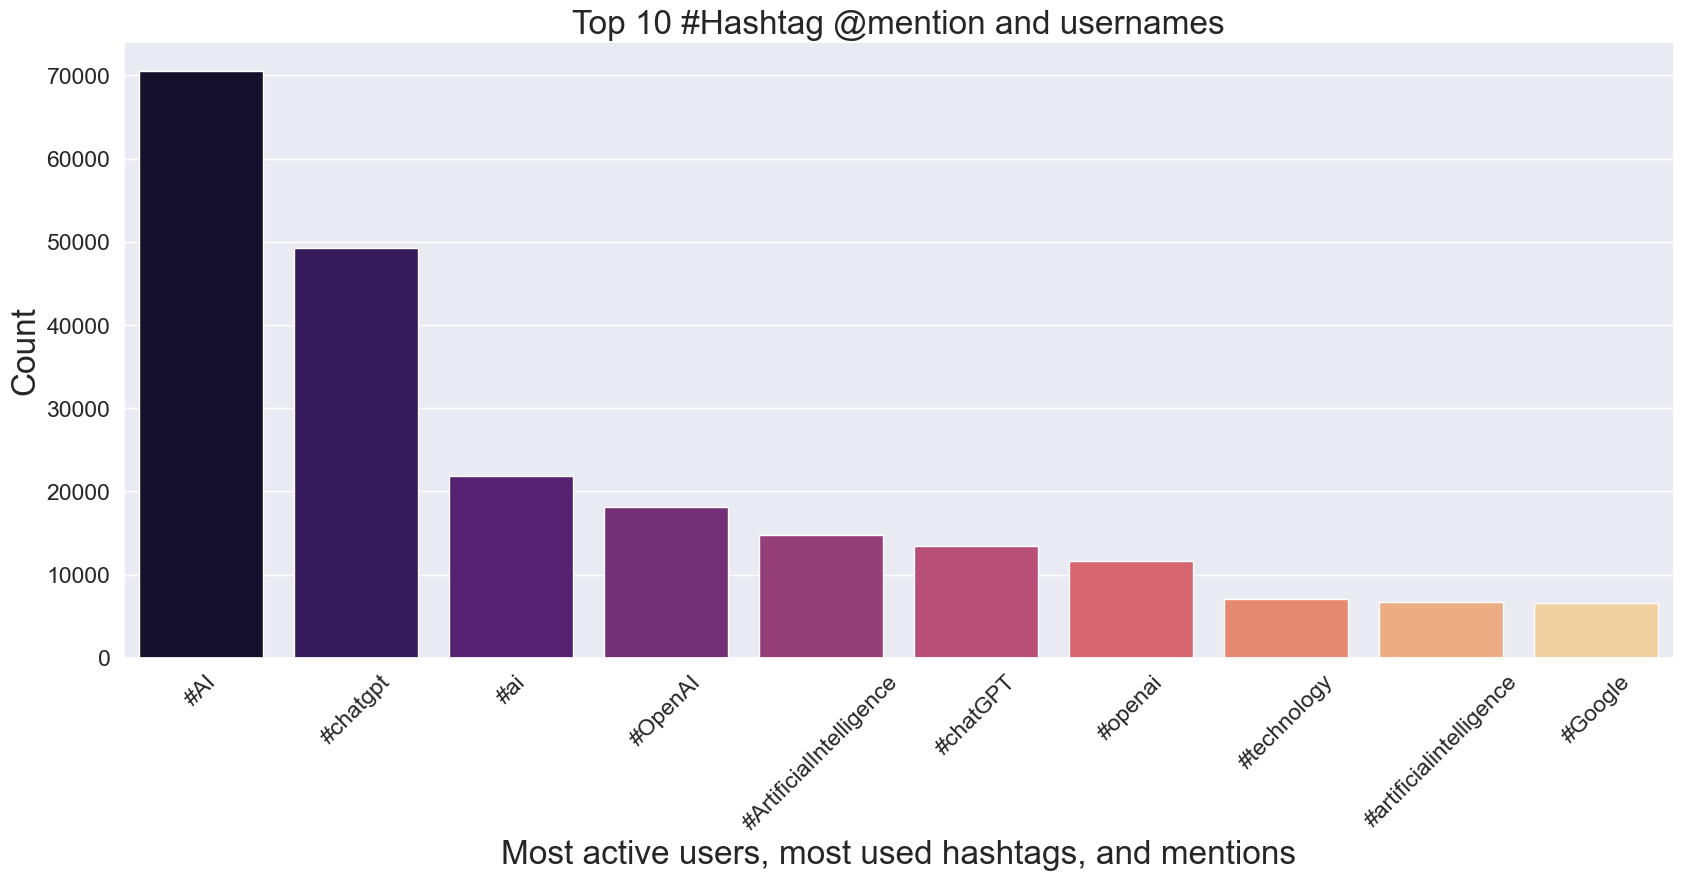

In [13]:
#Let's look at most active users, most used hashtags, and mentions
plt.figure(figsize=(20, 8))
sns.set(font_scale=1.5)
hashtags = df['content'].str.findall(r'#\w+')
hashtags_count = hashtags.explode().value_counts()
sns.barplot(x=hashtags_count.index[1:11], y=hashtags_count[1:11],palette='magma')
plt.title('Top 10 #Hashtag @mention and usernames',fontsize=24)
plt.xticks(rotation=45)
plt.xlabel('Most active users, most used hashtags, and mentions',fontsize=24)
plt.ylabel('Count',fontsize=24)
plt.show()

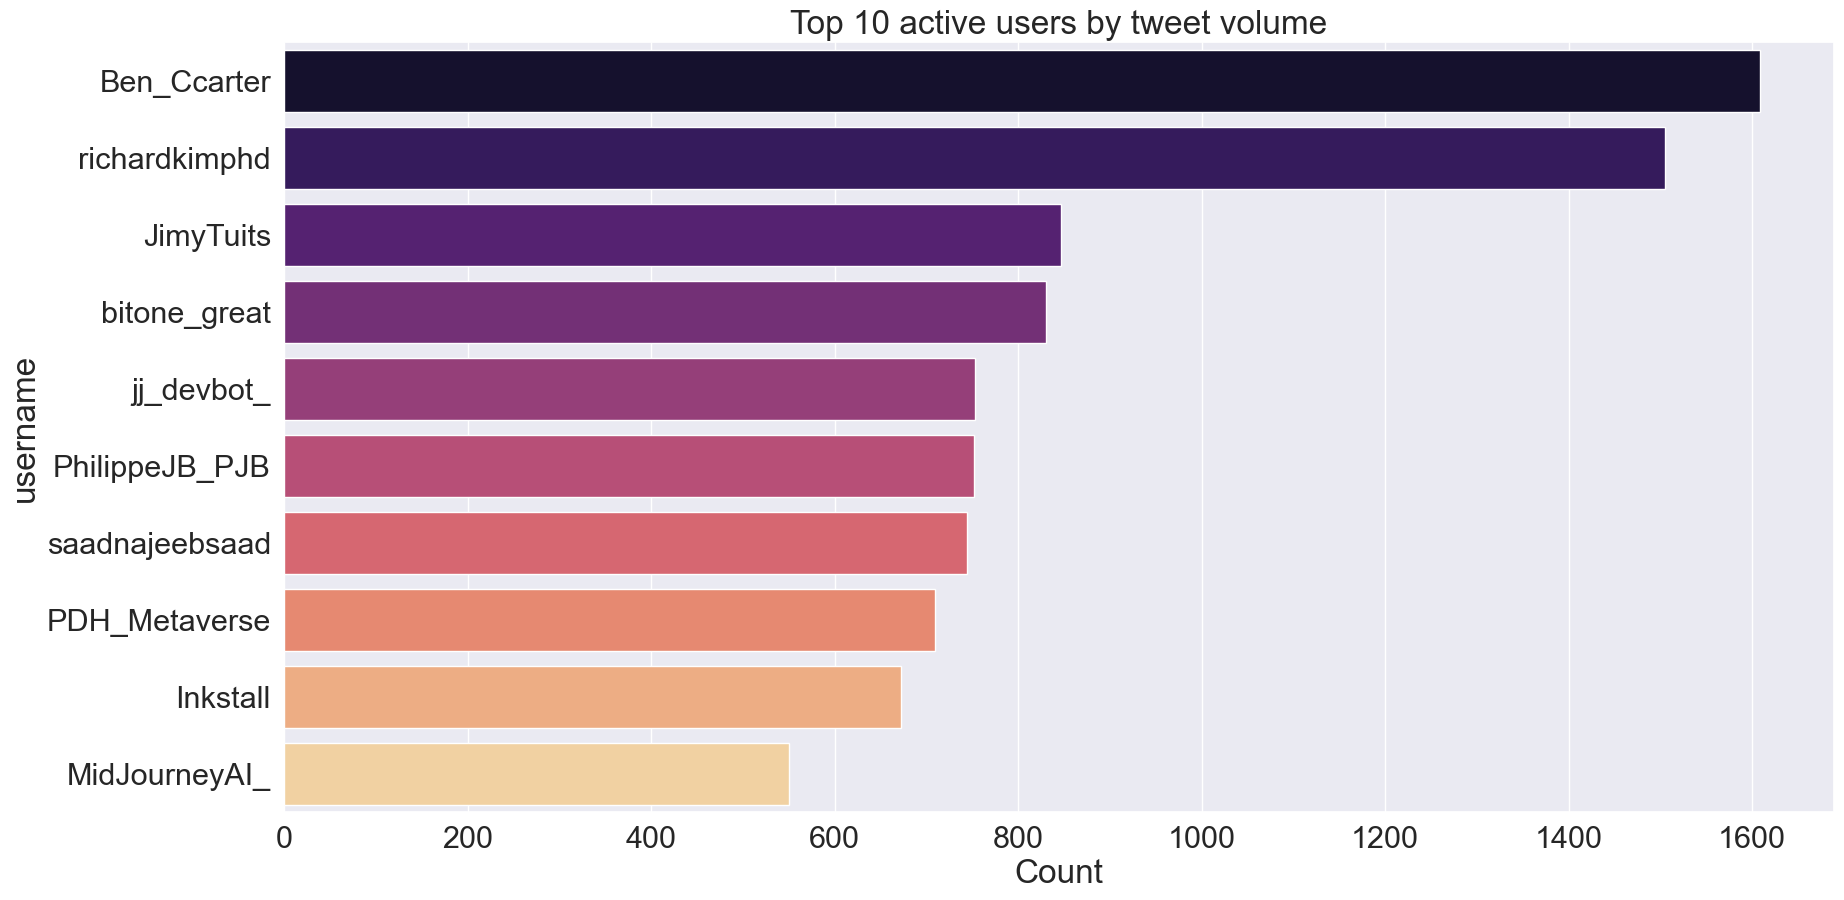

In [14]:
#Let's check top 10 active users by tweet volume

plt.figure(figsize=(20, 10))
sns.set(font_scale=2)
tweets_by_user = df.groupby('username').size().sort_values(ascending=False)
sns.barplot(x=tweets_by_user[:10], y=tweets_by_user[:10].index,palette='magma')
plt.title('Top 10 active users by tweet volume',fontsize=24)
plt.xlabel('Count',fontsize=24)
plt.ylabel('username',fontsize=24)
plt.show()



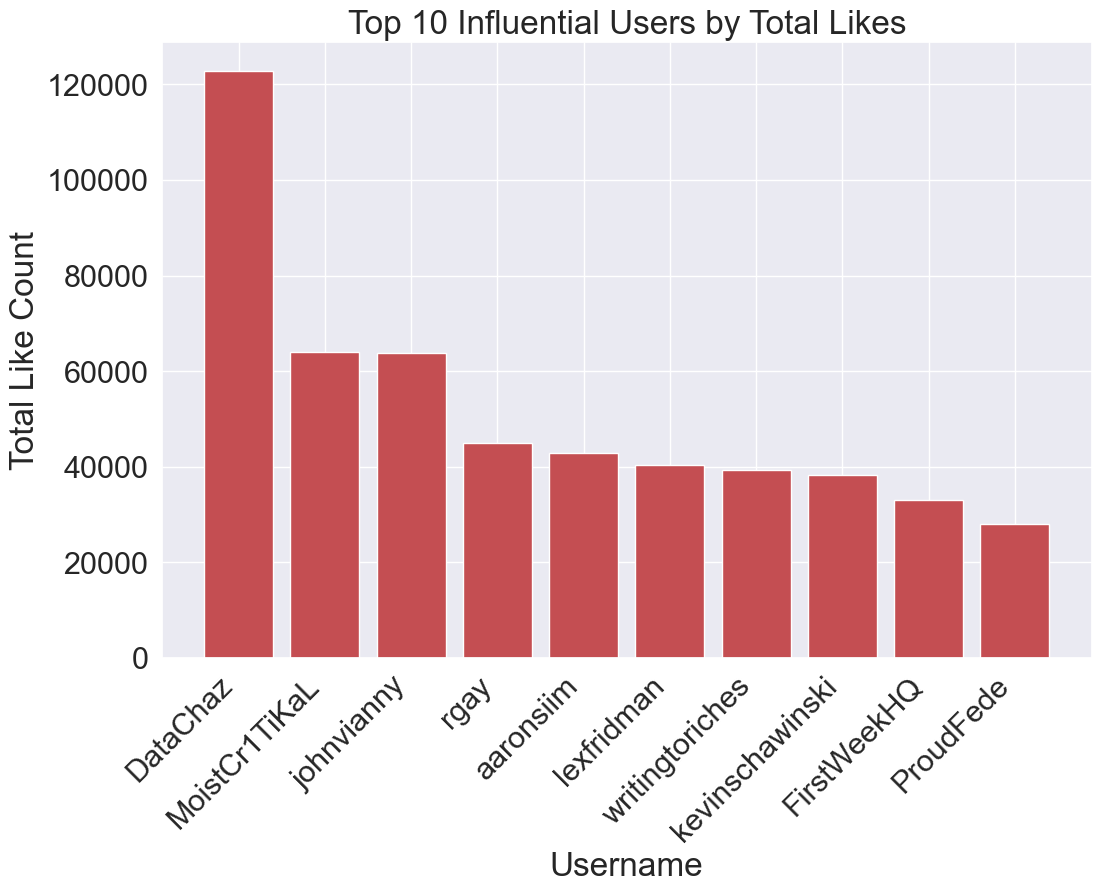

In [15]:
#Let's plot Top 10 Influential Users by Total Likes

user_likes = df.groupby('username')['like_count'].sum().reset_index()
user_likes_sorted = user_likes.sort_values(by='like_count', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(user_likes_sorted['username'], user_likes_sorted['like_count'], color='r')

plt.xlabel('Username')
plt.ylabel('Total Like Count')
plt.title('Top 10 Influential Users by Total Likes')

plt.xticks(rotation=45, ha='right')

plt.show()




In [16]:
#Stock Impact
start_date = '2023-01-04'
end_date = '2023-03-29'
ticker_symbols = ['MSFT', 'GOOGL', 'AMZN', 'META', 'AAPL','TSLA']
stocks_df = yf.download(ticker_symbols, start=start_date, end=end_date)['Adj Close']

C:\Users\yahya\anaconda3\lib\site-packages\yfinance\base.py:191: UserWarning:

Pandas requires version '2022.1' or newer of 'tzdata' (version '2021.1' currently installed).



[*********************100%%**********************]  6 of 6 completed


In [17]:
#Number of tweets per day
tweets_by_day = df.groupby(pd.Grouper(key='date', freq='D')).size().reset_index()
tweets_by_day.columns = ['date', 'count']

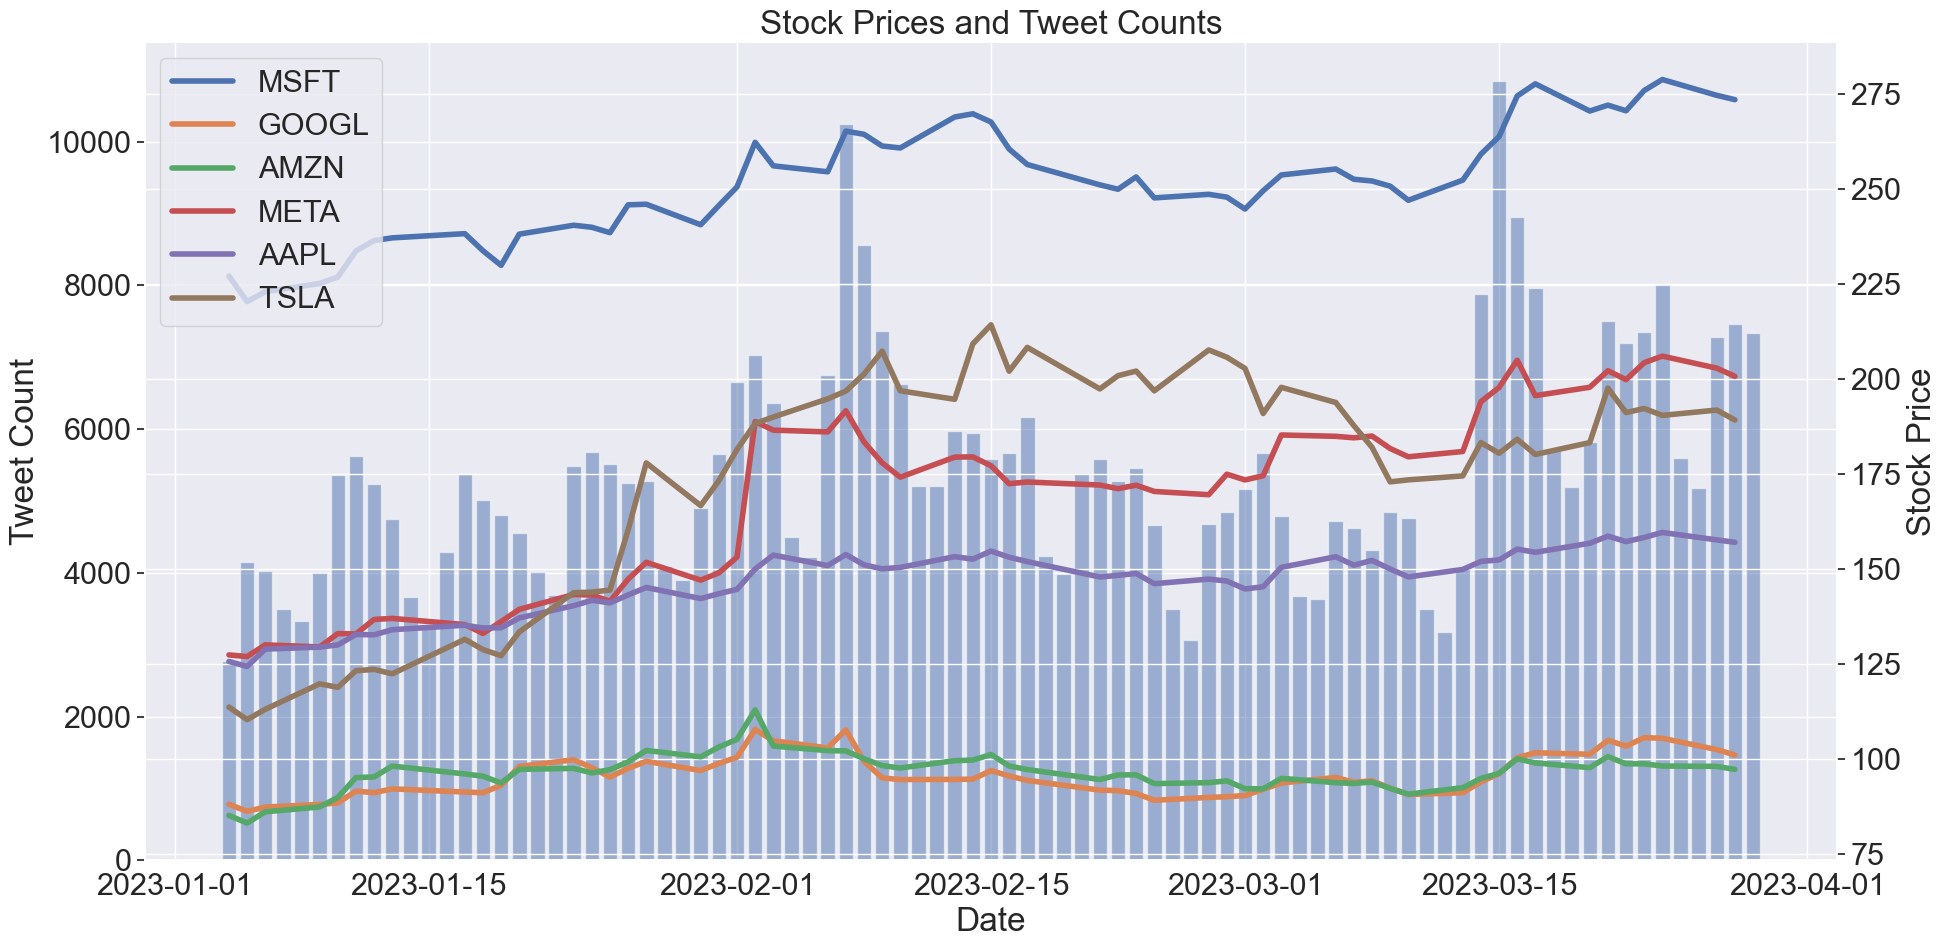

In [18]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.bar(tweets_by_day['date'], tweets_by_day['count'], alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Tweet Count')
ax1.tick_params(axis='x')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax2 = ax1.twinx()
for symbol in ticker_symbols:
    ax2.plot(stocks_df.index, stocks_df[symbol], label=symbol,linewidth=4)
    ax2.set_ylabel('Stock Price')
    ax2.legend(loc='upper left')

plt.title('Stock Prices and Tweet Counts')
plt.tight_layout()
plt.show()


In [19]:
#Let's perform the Text Analysis using Top Bigrams and Trigrams.

#We need the function to get n-grams

def get_top_n_ngrams(corpus, n=None, ngram=2):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]



In [20]:
#Get top 10 bigrams
common_bigrams = get_top_n_ngrams(df['processed_content'], 10, ngram=2)

#Get top 10 trigrams
common_trigrams = get_top_n_ngrams(df['processed_content'], 10, ngram=3)

#and perform the data object conversion

df_bigrams = pd.DataFrame(common_bigrams, columns=['NgramText', 'count'])
df_trigrams = pd.DataFrame(common_trigrams, columns=['NgramText', 'count'])



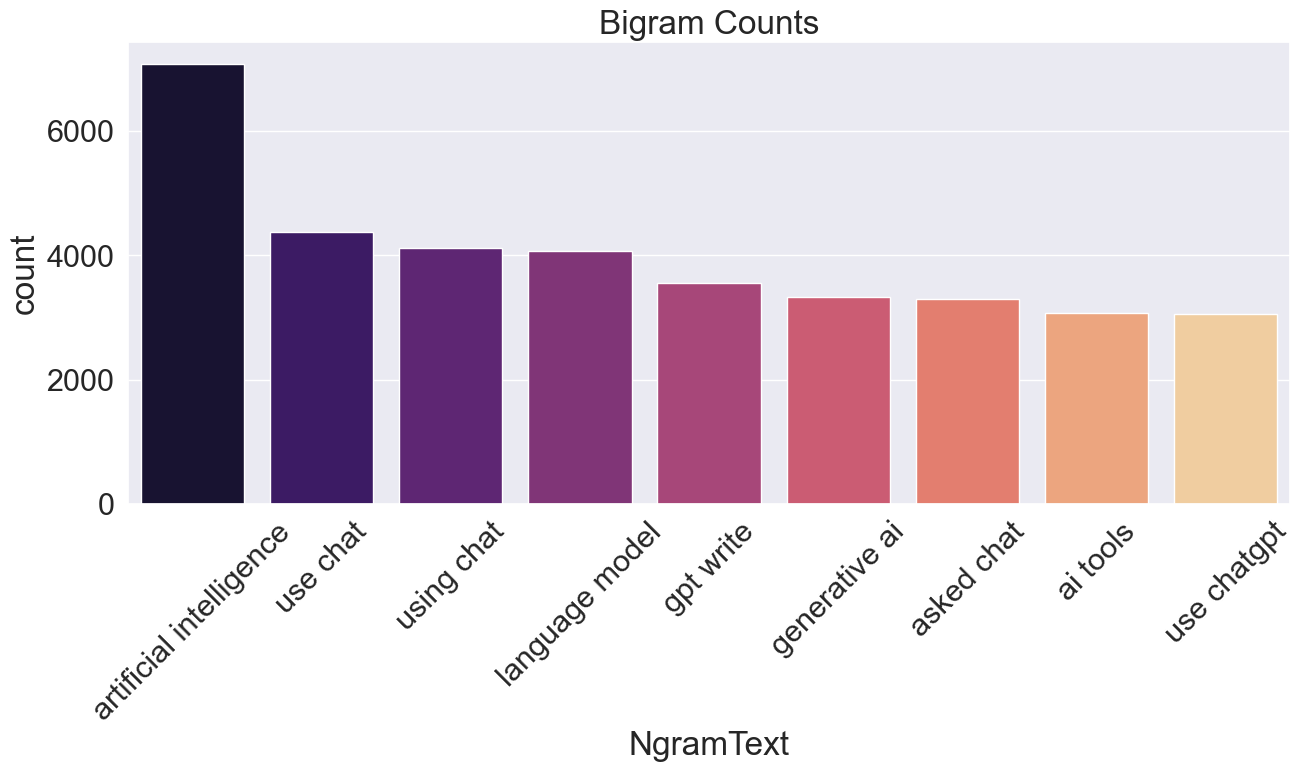

In [21]:
#Let's plot the top 10 bigram count

plt.figure(figsize=(15, 6))
sns.barplot(data=df_bigrams[1:], x='NgramText', y='count', palette='magma')
plt.title('Bigram Counts')
plt.xticks(rotation=45)
plt.show()



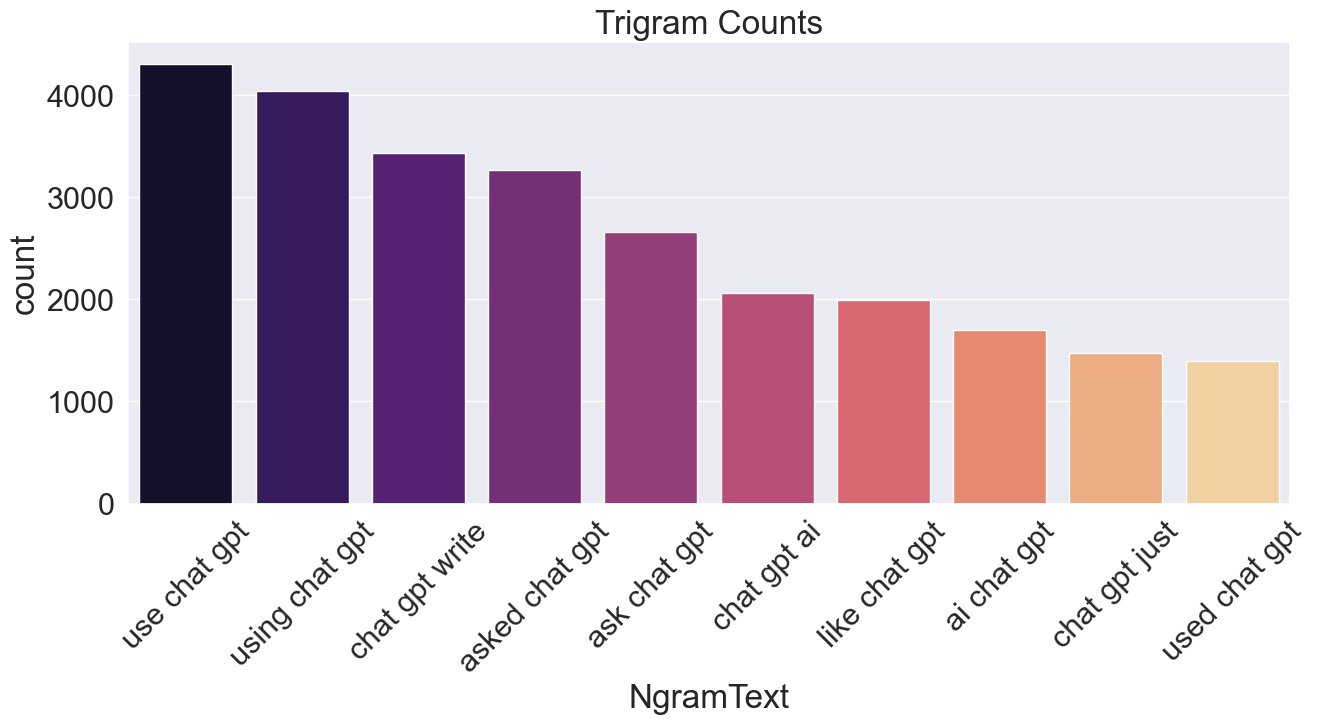

In [22]:
#Let's plot the top 10 trigram count
plt.figure(figsize=(15, 6))
sns.barplot(data=df_trigrams, x='NgramText', y='count', palette='magma')
plt.title('Trigram Counts')
plt.xticks(rotation=45)
plt.show()


In [27]:
#Let's exclude 'chat', 'gpt', and 'chatgpt' from n-grams to get better results focusing on other aspects related to ChatGPT.

#We need the modified function to exclude certain keywords from the ngrams
def get_top_n_ngrams(corpus, n=None, ngram=2, exclude_keywords=None):
    if exclude_keywords is None:
        exclude_keywords = []

    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Exclude n-grams containing specified keywords
    words_freq = [item for item in words_freq if not any(keyword in item[0] for keyword in exclude_keywords)]

    return words_freq[:n]



In [28]:
#Let's get top 10 bigrams
common_bigrams = get_top_n_ngrams(df['processed_content'], 10, ngram=2, exclude_keywords=['chat', 'gpt', 'chatgpt'])

In [29]:
#Let's get top 10 trigrams
common_trigrams = get_top_n_ngrams(df['processed_content'], 10, ngram=3, exclude_keywords=['chat', 'gpt', 'chatgpt'])

In [30]:
#converting the lists to data frames
df_bigrams = pd.DataFrame(common_bigrams, columns=['NgramText', 'count'])
df_trigrams = pd.DataFrame(common_trigrams, columns=['NgramText', 'count'])

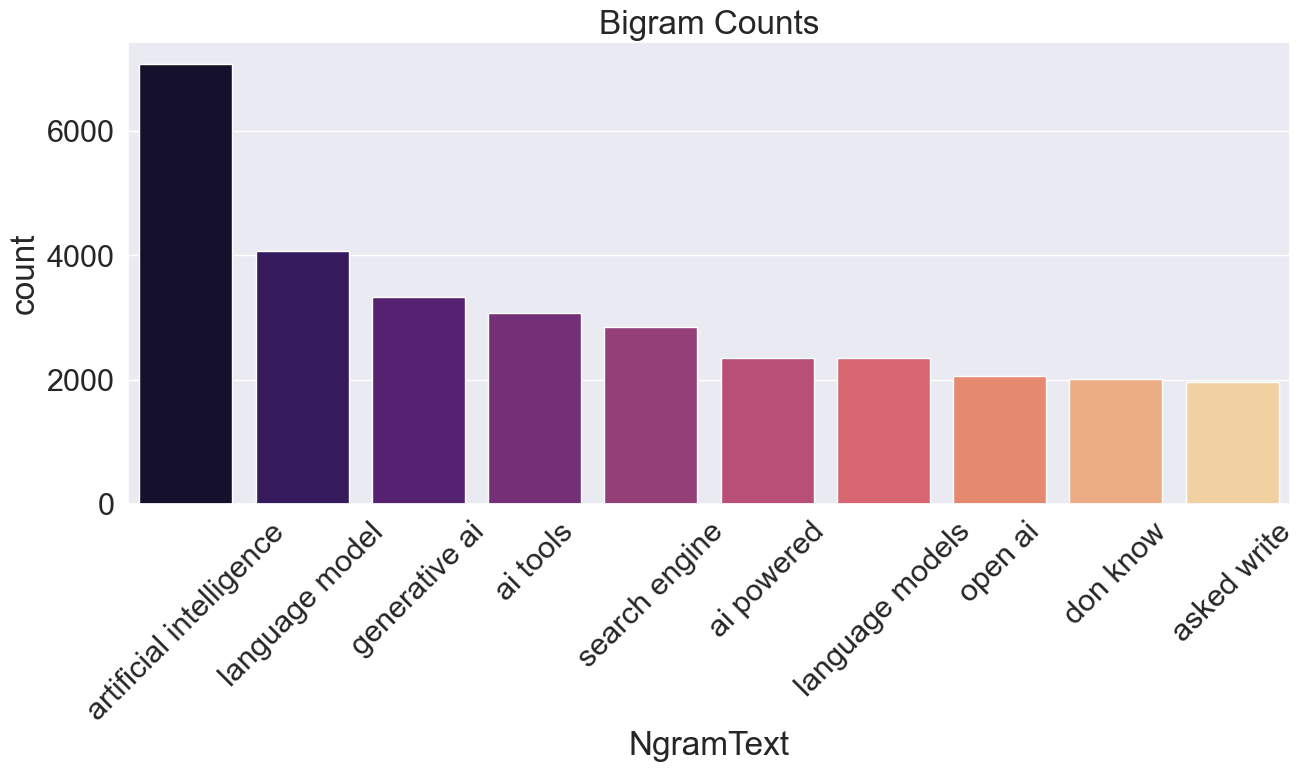

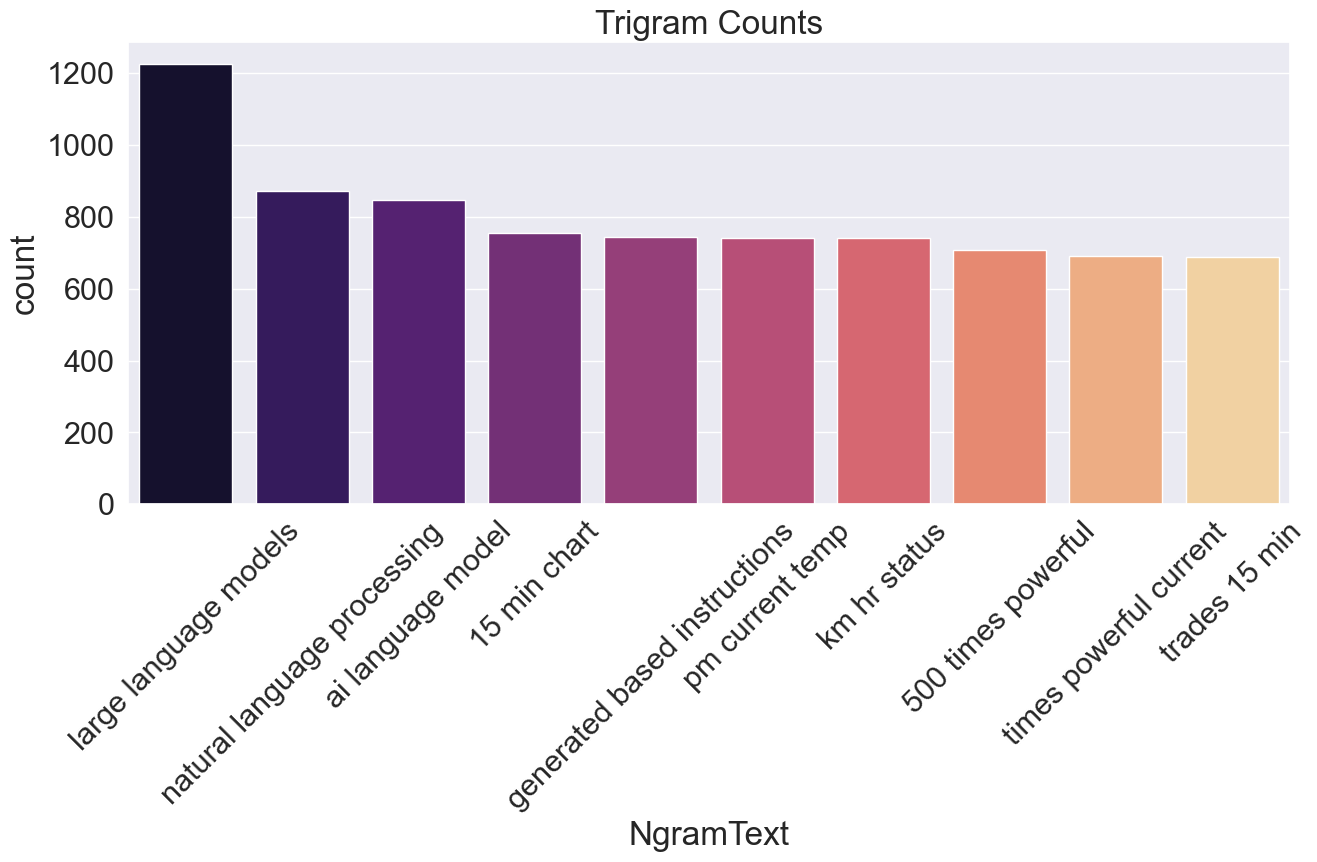

In [31]:
#Modified Bigram Counts:

plt.figure(figsize=(15, 6))
sns.barplot(data=df_bigrams, x='NgramText', y='count', palette='magma')
plt.title('Bigram Counts')
plt.xticks(rotation=45)
plt.show()

#Modified Trigram Counts:

plt.figure(figsize=(15, 6))
sns.barplot(data=df_trigrams, x='NgramText', y='count', palette='magma')
plt.title('Trigram Counts')
plt.xticks(rotation=45)
plt.show()

#NLP Word Clouds

#Initialize the lemmatizer:
wordnet_lem = WordNetLemmatizer()

#Lemmatize processed text and join everything in a list:
df['content_lem'] = df['processed_content'].apply(wordnet_lem.lemmatize)
all_words_lem = ' '.join([word for word in df['content_lem']])



In [32]:
#Unigram Word Cloud:

from random import choice

def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#1DA1F2', '#00CC96', '#FF5733', '#FFC300', '#E91E63', '#9C27B0', '#673AB7']
    return choice(colors)

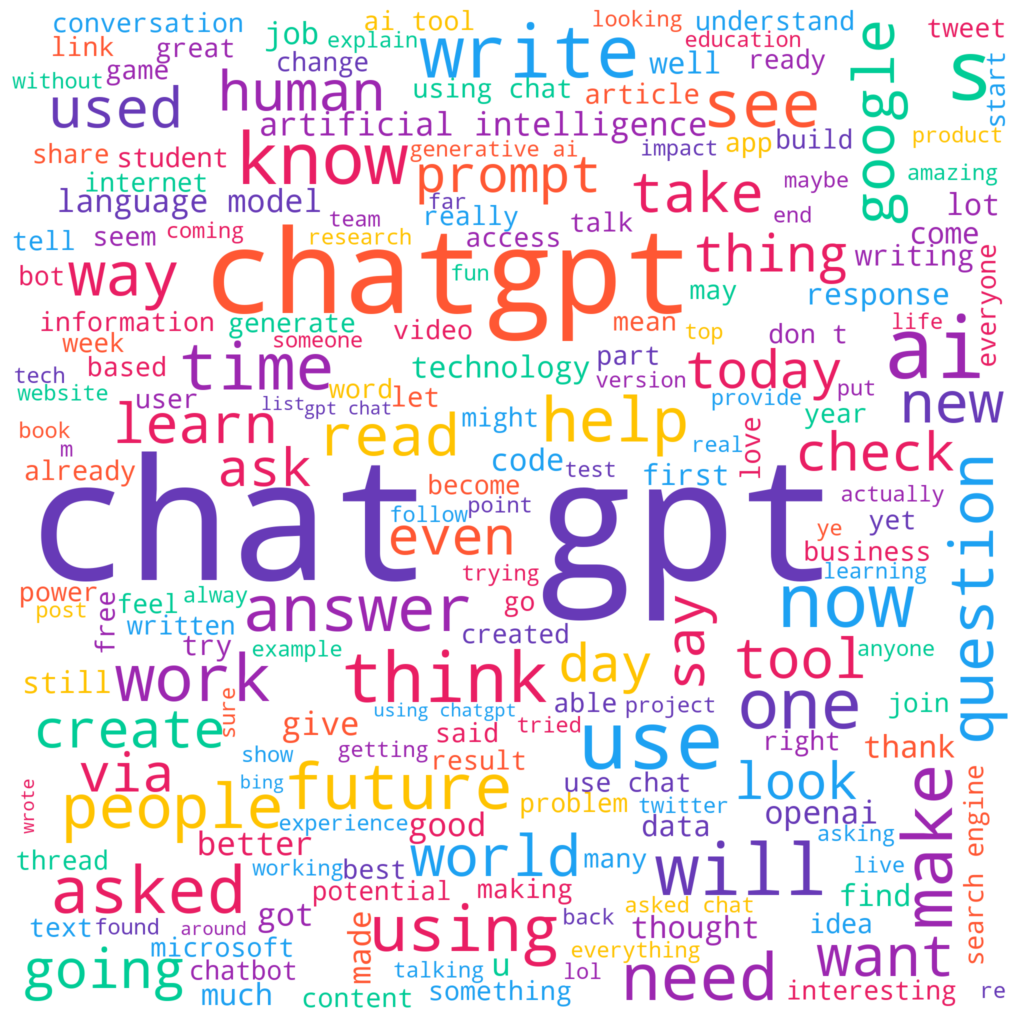

In [33]:
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=2000, width=2000,
background_color="white",
stopwords=stopwords, color_func=custom_color_func).generate(all_words_lem)

plt.figure(figsize=[10, 10])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=custom_color_func), interpolation="bilinear")

plt.savefig("twitter_unigram.png", format="png")

plt.show()


In [34]:
#Mentions Word Cloud:

#Extract mentions and concatenate all mentions in one string
all_mentions = ' '.join([mention[1:] for mentions in df['content'].str.findall(r'@\w+') for mention in mentions])


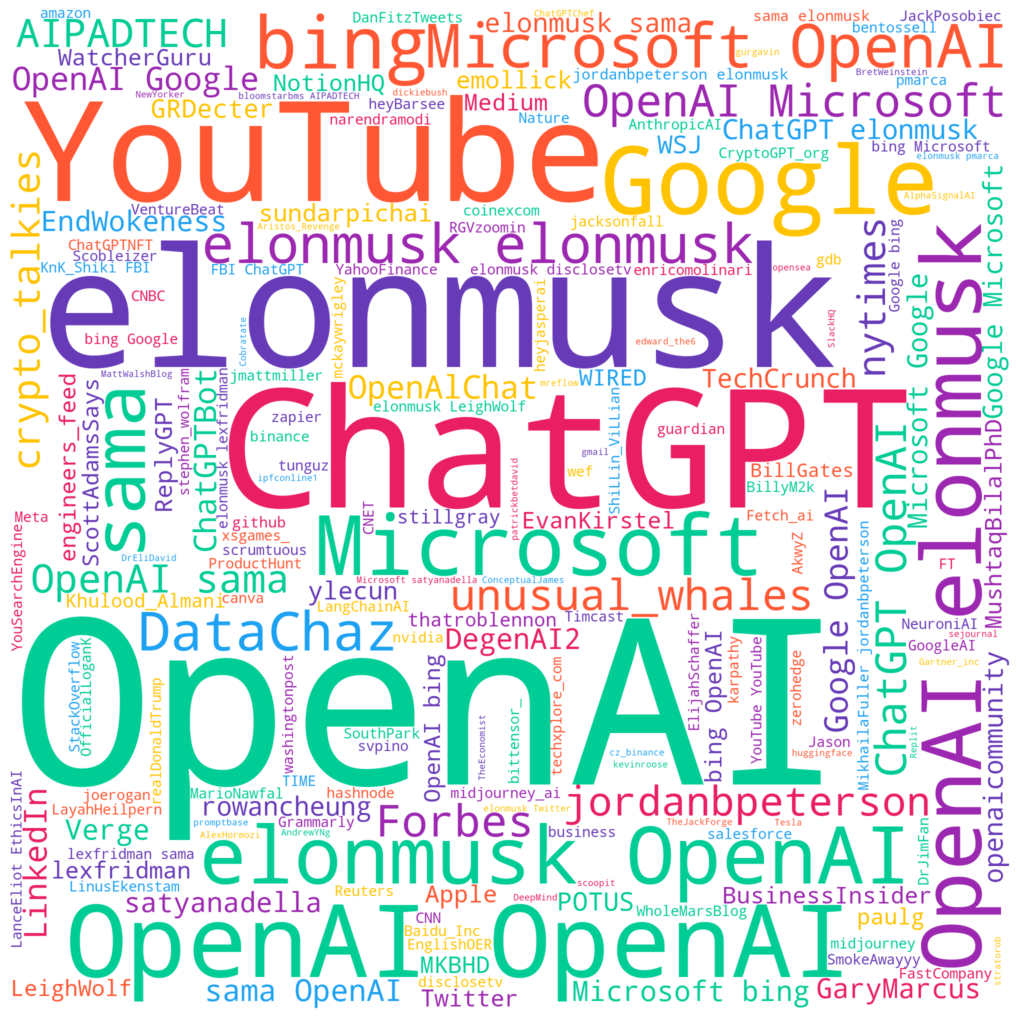

In [35]:

#Generate a word cloud image
wordcloud_twitter = WordCloud(height=2000, width=2000,
background_color="white",
stopwords=stopwords, color_func=custom_color_func).generate(all_mentions)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=custom_color_func), interpolation="bilinear")

plt.savefig("twitter_logo_unigram_mentions.png", format="png")

plt.show()


In [36]:
#Hashtag Word Cloud

#Extract hashtags and concatenate all hashtags in one string
all_hashtags = ' '.join([hashtag[1:] for hashtags in df['content'].str.findall(r'#\w+') for hashtag in hashtags])

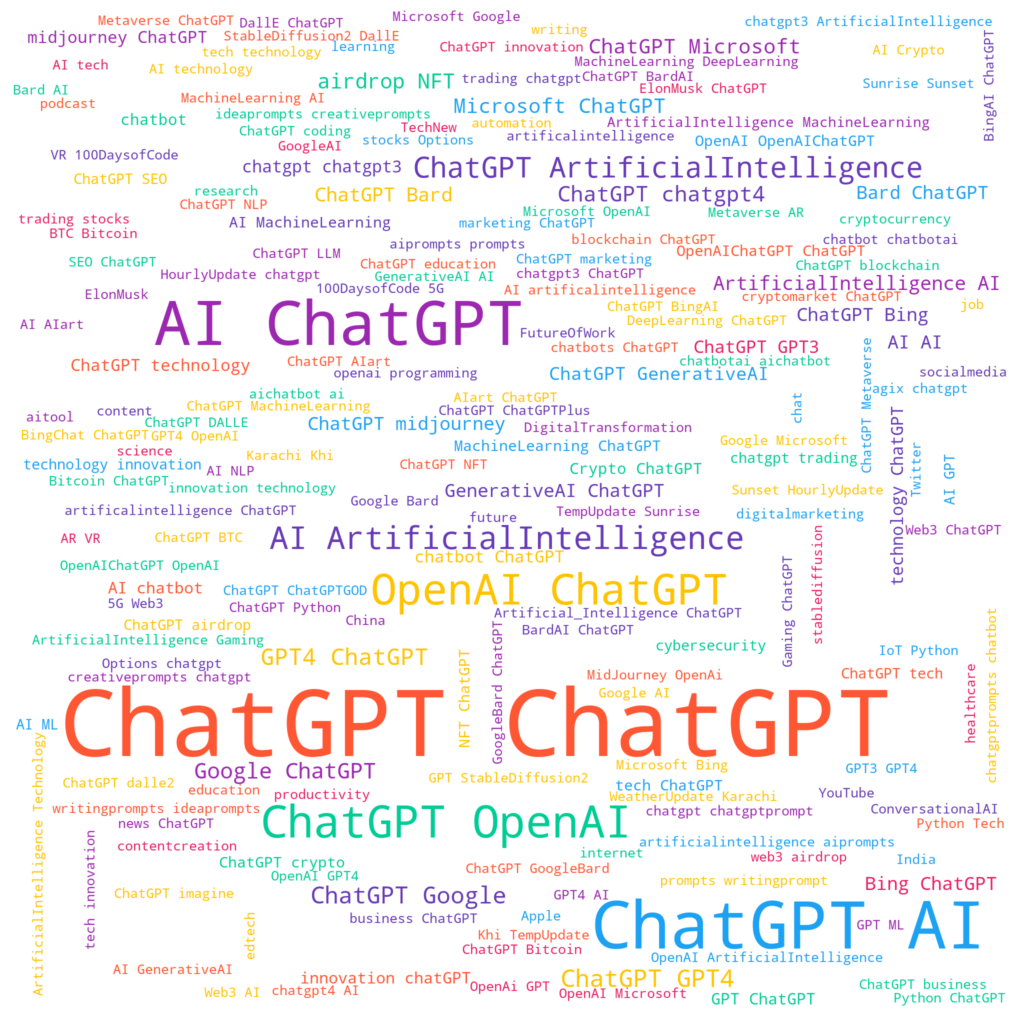

In [37]:
#Generate a word cloud image
wordcloud_twitter = WordCloud(height=2000, width=2000,
background_color="white",
stopwords=stopwords, color_func=custom_color_func).generate(all_hashtags)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=custom_color_func), interpolation="bilinear")

plt.savefig("twitter_logo_unigram_hashtags.png", format="png")

plt.show()

#### Thanks For Your Time ♥